<a href="https://colab.research.google.com/github/prachuryanath/TF-Learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2 : SkimLit 

In this project, we're going to be putting what we've learned into practice.

More specificially, we're going to be replicating the deep learning model behind the 2017 paper `PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts`.

When it was released, the paper presented a new dataset called `PubMed 200k RCT which consists of ~200,000 labelled Randomized Controlled Trial (RCT) abstracts`.

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.

### **Problem in a sentence**
*The number of RCT papers released is continuing to increase, those without structured abstracts can be hard to read and in turn slow down researchers moving through the literature.*

### **Solution in a sentence**
*Create an NLP model to classify abstract sentences into the role they play (e.g. objective, methods, results, etc) to enable researchers to skim through the literature (hence SkimLit 🤓🔥) and dive deeper when necessary.*

## What we're going to cover
Time to take what we've learned in the NLP fundmentals notebook and build our biggest NLP model yet:

* Downloading a text dataset (PubMed RCT200k from GitHub)
* Writing a preprocessing function to prepare our data for modelling
* Setting up a series of modelling experiments
  * Making a baseline (TF-IDF classifier)
  * Deep models with different combinations of: token embeddings, character embeddings, pretrained embeddings, positional embeddings
* Building our first multimodal model (taking multiple types of data inputs)
  * Replicating the model architecture from https://arxiv.org/pdf/1612.05251.pdf
* Find the most wrong predictions
* Making predictions on PubMed abstracts from the wild

In [1]:
# Check for GPU
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Get data

Before we can start building a model, we've got to download the PubMed 200k RCT dataset.

In a phenomenal act of kindness, the authors of the paper have made the data they used for their research availably publically and for free in the form of .txt files on GitHub.

We can copy them to our local directory using git clone `https://github.com/Franck-Dernoncourt/pubmed-rct.`

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 30, done.
remote: Total 30 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (30/30), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


Looking at the README file from the GitHub page, we get the following information:

* `PubMed 20k` is a subset of `PubMed 200k`. I.e., any abstract present in `PubMed 20k` is also present in `PubMed 200k`.
* `PubMed_200k_RCT` is the same as `PubMed_200k_RCT_numbers_replaced_with_at_sign`, except that in the latter all numbers had been replaced by @. (same for `PubMed_20k_RCT` vs. `PubMed_20k_RCT_numbers_replaced_with_at_sign`).
* Since Github file size limit is 100 MiB, we had to compress `PubMed_200k_RCT\train.7z` and `PubMed_200k_RCT_numbers_replaced_with_at_sign\train.zip`. To uncompress train.7z, you may use 7-Zip on Windows, Keka on Mac OS X, or p7zip on Linux.

To begin with, the dataset we're going to be focused on is `PubMed_20k_RCT_numbers_replaced_with_at_sign`.



In [3]:
# Check what files are in the PubMed_20K dataset 
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


Beautiful, looks like we've got three separate text files:

* **train.txt** - *training samples.*
* **dev.txt** - *dev is short for development set, which is another name for validation set (in our case, we'll be using and referring to this file as our validation set).*
* **test.txt** - *test samples.*

In [4]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

To get familiar and understand how we have to prepare our data for our deep learning models, we've got to visualize it.

Because our data is in the form of text files, let's write some code to read each of the lines in a target file.

In [6]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list

  Args:
    filename : a string containing the target filepath to read.

  Returns:
    A list of strings with one string per line from the target filename.
    For example:
    ["this is the first line of filename",
    "this is the second line of filename",
    ...]
  """
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Let's write a function to perform the following steps:

* Take a target file of abstract samples.
* Read the lines in the target file.
* For each line in the target file:
  * If the line begins with ### mark it as an abstract ID and the beginning of a new abstract.
    * Keep count of the number of lines in a sample.
  * If the line begins with \n mark it as the end of an abstract sample.
    * Keep count of the total lines in a sample.
  * Record the text before the \t as the label of the line.
  * Record the text after the \t as the text of the line.
* Return all of the lines in the target text file as a list of dictionaries containing the key/value pairs:
  * "line_number" - the position of the line in the abstract (e.g. 3).
  * "target" - the role of the line in the abstract (e.g. OBJECTIVE).
  * "text" - the text of the line in the abstract.
  * "total_lines" - the total lines in an abstract sample (e.g. 14).
* Abstract ID's and newlines should be omitted from the returned preprocessed data.

In [9]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence
  number the target line is.

  Args:
    filename : a string of the target text file to read and extract line data from.
  
  Returns:
     A list of dictionaries each containing a line from an abstract,
     the lines label, the lines position in the abstract and the total
     number of lines in the abstract where the line is from. For example:

     [{"target":'Conclusion',
     "text": "The study couldn't have gone better",
     "line_number":8,
     "total_lines":9}]
  """
  input_lines = get_lines(filename)     # get all lines from filename
  abstract_lines = ""                   # create an empty abstract
  abstract_samples = []                 # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith('###'):          # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [10]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 509 ms, sys: 135 ms, total: 645 ms
Wall time: 646 ms


In [11]:
# Check the first abstract of our training data
train_samples[:10]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

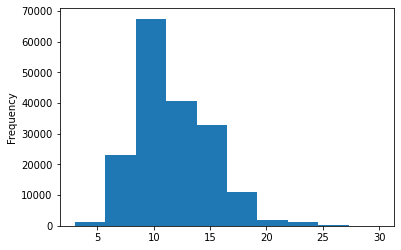

In [14]:
train_df.total_lines.plot.hist();

### Get lists of sentences

In [15]:
# Convert abstract text lines into lists 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [16]:
# View first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels 

We're going to create one hot and label encoded labels.

We could get away with just making label encoded labels, however, TensorFlow's CategoricalCrossentropy loss function likes to have one hot encoded labels (this will enable us to use label smoothing later on).

To numerically encode labels we'll use Scikit-Learn's OneHotEncoder and LabelEncoder classes.



In [17]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [18]:
# Extract labels ("target" columns) and encode them into integers 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
# Get class names and number of classes from LabelEncoder instance 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))